In [4]:
from rdkit import Chem
import py3Dmol
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True


In [7]:
def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    # viewer.addPropertyLabels("atom","","")

    # for i, at in enumerate(mol):
    #     default = {"stick": {'color': 'black'}}
    #     viewer.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))

    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer



In [13]:
mol = Chem.SDMolSupplier('org_4.sdf')[0]
viewer = MolTo3DView(mol, size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [11]:
def get_torsions(mol_list):
    atom_counter = 0
    torsionList = []
    dihedralList = []
    for m in mol_list:
        torsionSmarts = '[!$(*#*)&!D1]-&!@[!$(*#*)&!D1]'
        torsionQuery = Chem.MolFromSmarts(torsionSmarts)
        matches = m.GetSubstructMatches(torsionQuery)
        conf = m.GetConformer()
        for match in matches:
            idx2 = match[0]
            idx3 = match[1]
            bond = m.GetBondBetweenAtoms(idx2, idx3)
            jAtom = m.GetAtomWithIdx(idx2)
            kAtom = m.GetAtomWithIdx(idx3)
            for b1 in jAtom.GetBonds():
                if (b1.GetIdx() == bond.GetIdx()):
                    continue
                idx1 = b1.GetOtherAtomIdx(idx2)
                for b2 in kAtom.GetBonds():
                    if ((b2.GetIdx() == bond.GetIdx())
                            or (b2.GetIdx() == b1.GetIdx())):
                        continue
                    idx4 = b2.GetOtherAtomIdx(idx3)
                    # skip 3-membered rings
                    if (idx4 == idx1):
                        continue
                    # skip torsions that include hydrogens
                    #                     if ((m.GetAtomWithIdx(idx1).GetAtomicNum() == 1)
                    #                         or (m.GetAtomWithIdx(idx4).GetAtomicNum() == 1)):
                    #                         continue
                    if m.GetAtomWithIdx(idx4).IsInRing():
                        torsionList.append(
                            (idx4 + atom_counter, idx3 + atom_counter, idx2 + atom_counter, idx1 + atom_counter))
                        break
                    else:
                        torsionList.append(
                            (idx1 + atom_counter, idx2 + atom_counter, idx3 + atom_counter, idx4 + atom_counter))
                        break
                break

        atom_counter += m.GetNumAtoms()
    return torsionList


In [15]:
rotable_bonds = get_torsions([mol])

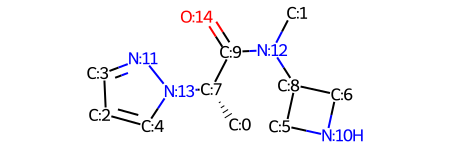

In [16]:
def show_atom_number(mol, label):
    # mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetProp(label, str(i))
    mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    return mol
show_atom_number(mol, 'molAtomMapNumber')

In [17]:
rotable_bonds

[(0, 7, 9, 14), (4, 13, 7, 0), (6, 8, 12, 1), (14, 9, 12, 1)]

In [14]:
from rdkit.Chem import rdMolTransforms
import copy

def SetDihedral(conf, atom_idx, new_vale):
    rdMolTransforms.SetDihedralDeg(conf, atom_idx[0], atom_idx[1], atom_idx[2], atom_idx[3], new_vale)


def GetDihedral(conf, atom_idx):
    return rdMolTransforms.GetDihedralDeg(conf, atom_idx[0], atom_idx[1], atom_idx[2], atom_idx[3])

def apply_changes(mol, values, rotable_bonds):
    opt_mol = copy.deepcopy(mol)
    #     opt_mol = add_rdkit_conformer(opt_mol)

    # apply rotations
    [SetDihedral(opt_mol.GetConformer(), rotable_bonds[r], values[r]) for r in range(len(rotable_bonds))]

    #     # apply transformation matrix
    #     rdMolTransforms.TransformConformer(opt_mol.GetConformer(), GetTransformationMatrix(values[:6]))

    return opt_mol

In [19]:
org_angle = []
for rot_bond in rotable_bonds:
    org_angle.append(GetDihedral(mol.GetConformer(), rot_bond))
print(org_angle)
import numpy as np
org_angle = np.array(org_angle)

[31.37622954888284, -65.04504580589654, 48.50139978680959, 160.47669975266095]


In [26]:
org_angle[0] -= 30
# org_angle[1] += 60
new_mol = apply_changes(mol, org_angle, rotable_bonds)

In [27]:
viewer = MolTo3DView(new_mol, size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [22]:
viewer = MolTo3DView(mol, size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [169]:
# get conformer
coords = mol.GetConformer().GetPositions()
print(coords)

[[ 1.306  -3.0661  0.2768]
 [ 2.41   -2.3947 -0.5528]
 [ 0.3649  1.4531 -1.0923]
 [-0.1949 -2.1376 -2.789 ]
 [-0.4855  2.7069 -0.8899]
 [ 0.4899 -1.8792  0.8071]
 [-0.4651 -2.3871 -4.1049]
 [ 1.7574 -1.3439 -3.7638]
 [ 1.0919 -1.538  -2.5802]
 [ 1.6906 -1.1959 -1.2256]
 [ 0.0547  0.373  -0.062 ]
 [-0.1768  3.6888 -1.9391]
 [ 0.6853 -0.8347 -0.2112]
 [-0.7221  0.5604  0.8728]
 [ 0.8428 -1.8927 -5.1306]]


In [170]:
coords2 = new_mol.GetConformer().GetPositions()
print(coords2)

[[ 1.306      -3.0661      0.2768    ]
 [ 2.41       -2.3947     -0.5528    ]
 [ 0.3649      1.4531     -1.0923    ]
 [-0.1949     -2.1376     -2.789     ]
 [-0.4855      2.7069     -0.8899    ]
 [ 0.4899     -1.8792      0.8071    ]
 [-0.4651     -2.3871     -4.1049    ]
 [ 1.7574     -1.3439     -3.7638    ]
 [ 1.0919     -1.538      -2.5802    ]
 [ 1.6906     -1.1959     -1.2256    ]
 [ 0.0547      0.373      -0.062     ]
 [ 0.38917456  3.87092573 -0.68931974]
 [ 0.6853     -0.8347     -0.2112    ]
 [-0.7221      0.5604      0.8728    ]
 [ 0.8428     -1.8927     -5.1306    ]]


In [1]:
import torch
from torchmdnet.datasets import PCQM4MV2

raw_path = '/sharefs/sharefs-skfeng/Denoising/data/pcq/'
pcq_data = PCQM4MV2(raw_path)

/home/fengshikun/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
MOL_LST = np.load("mol_iter_all.npy", allow_pickle=True)

In [25]:
idx = 19999
mol = MOL_LST[idx]
h_mol = Chem.AddHs(mol)
atom_num = mol.GetNumAtoms()
h_coords = pcq_data[idx].pos
all_atom_num = pcq_data[idx].pos.shape[0]

In [26]:
viewer = MolTo3DView(mol, size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [27]:
from rdkit.Geometry import Point3D
coord_conf = h_mol.GetConformer()
for i in range(atom_num, all_atom_num):
    x,y,z = h_coords[i]
    coord_conf.SetAtomPosition(i, Point3D(float(x), float(y), float(z)))

In [30]:
rotable_bonds = get_torsions([h_mol])
print(rotable_bonds)
org_angle = []
for rot_bond in rotable_bonds:
    org_angle.append(GetDihedral(h_mol.GetConformer(), rot_bond))
print(org_angle)
org_angle = np.array(org_angle)
org_angle -= 60
print(org_angle)
# org_angle[1] += 60
new_h_mol = apply_changes(h_mol, org_angle, rotable_bonds)
viewer = MolTo3DView(new_h_mol, size=(600, 300), style='stick')
viewer.show()

[(15, 0, 8, 5), (18, 1, 14, 10), (3, 2, 4, 6), (4, 2, 3, 5), (2, 3, 5, 8), (2, 4, 6, 9), (3, 5, 8, 0), (4, 6, 9, 7), (10, 7, 9, 6), (9, 7, 10, 14), (0, 8, 11, 35), (6, 9, 12, 36), (7, 10, 14, 1)]
[60.84614566081024, 59.43538532142763, 177.37025998320112, -179.95191393462048, 178.5381864168149, 177.6591033725869, -176.60603316334874, 174.30429407160685, 65.4429929894759, -151.45858197743527, 59.18146006079374, -72.53288396535667, -177.59529691531299]
[   0.84614566   -0.56461468  117.37025998 -239.95191393  118.53818642
  117.65910337 -236.60603316  114.30429407    5.44299299 -211.45858198
   -0.81853994 -132.53288397 -237.59529692]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [29]:
viewer = MolTo3DView(mol, size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [205]:
from tqdm import tqdm
total_num = len(MOL_LST)
h_mol_lst = []
for idx in tqdm(range(total_num)):
    mol = MOL_LST[idx]
    h_mol = Chem.AddHs(mol)
    atom_num = mol.GetNumAtoms()
    h_coords = pcq_data[idx].pos
    all_atom_num = pcq_data[idx].pos.shape[0]
    coord_conf = h_mol.GetConformer()
    for i in range(atom_num, all_atom_num):
        x,y,z = h_coords[i]
        coord_conf.SetAtomPosition(i, Point3D(float(x), float(y), float(z)))
    h_mol_lst.append(h_mol)
    

100%|██████████| 3378606/3378606 [15:34<00:00, 3616.12it/s] 


In [206]:
np.save('h_mol_lst.npy', h_mol_lst)

In [210]:
viewer = MolTo3DView(h_mol_lst[200], size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [211]:
viewer = MolTo3DView(MOL_LST[200], size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [3]:
total_num = len(pcq_data)
MOL_LST2 = np.load("h_mol_lst.npy", allow_pickle=True)

In [6]:
from tqdm import tqdm
abnormal_mol = []
abnormal_idx = []
for idx in tqdm(range(total_num)):
    mol = MOL_LST2[idx]
    atom_num = mol.GetNumAtoms()
    all_atom_num = pcq_data[idx].pos.shape[0]
    if atom_num != all_atom_num:
        abnormal_idx.append(idx)
        abnormal_mol.append(mol)


100%|██████████| 3378606/3378606 [03:56<00:00, 14258.79it/s]


In [15]:
abnormal_idx

[51128,
 142541,
 155174,
 155175,
 155176,
 155180,
 155181,
 193600,
 411357,
 505556,
 1756391,
 1756392,
 2064546,
 2100882,
 2119947,
 2539039,
 2620153,
 2690488,
 2690489,
 2885109,
 2885110,
 2980839,
 2992920,
 3003839,
 3006497,
 3096168,
 3132431,
 3132432,
 3143920,
 3143921,
 3208535,
 3318575]

In [26]:
viewer = MolTo3DView(MOL_LST2[1001], size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

: 

In [25]:
viewer = MolTo3DView(MOL_LST[1001], size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

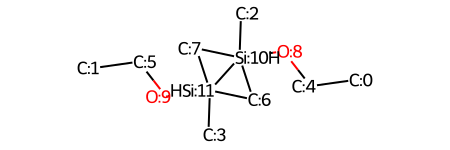

In [22]:
show_atom_number(MOL_LST[abnormal_idx[10]], 'molAtomMapNumber')